In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
from sklearn.model_selection import train_test_split

c:\Users\abdel\.conda\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\abdel\.conda\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\abdel\.conda\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Define data path
train_data_dir = "Images/IMBALANCED/Train"
validation_data_dir = "Images/IMBALANCED/Valid"
test_data_dir = "Images/IMBALANCED/Test"


# Define hyperparameters
IMAGE_SIZE = 160
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
NUM_CLASSES = 5
# Load MobileNet V2 pre-trained model
mobilenet_v2 = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                                 include_top=False,
                                                 weights='imagenet')


# Load data and split into training and validation sets
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(validation_data_dir,
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=16,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=16,
                                                shuffle=False,
                                                class_mode='categorical')

Found 58830 images belonging to 5 classes.
Found 13068 images belonging to 5 classes.
Found 6540 images belonging to 5 classes.


In [3]:
# Add a global average pooling layer and a dense output layer
#Model 1
# for layer in mobilenet_v2.layers[:-4]:
#     layer.trainable = False
    
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_v2.output)
# flatten = tf.keras.layers.Flatten()(global_average_layer)
# dense1 = tf.keras.layers.Dense(512, 'relu')(flatten)
# dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
# dense2 = tf.keras.layers.Dense(256, 'relu')(dropout1)
# dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
# output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dropout2)
# ----------------------------------------
#Model 2
for layer in mobilenet_v2.layers[:-5]:
    layer.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_v2.output)
output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(global_average_layer)
model = tf.keras.models.Model(inputs=mobilenet_v2.input, outputs=output_layer)
# ----------------------------------------
#Model 3
# base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
#                          include_top=False,
#                          weights='imagenet')

# # freeze the base model layers
# base_model.trainable = False

# # add the classification head
# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])
# Define the model

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [4]:
# x_train, x_val, y_train, y_val = train_test_split(data[0][0], data[0][1], test_size=0.2, random_state=42)
# print(x_train.shape, x_val.shape)
# train_generator = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_generator = train_generator.shuffle(buffer_size=1024).batch(BATCH_SIZE)

# val_generator = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_generator = val_generator.batch(BATCH_SIZE)

# Train the model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

class EvaluateEpochEnd(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        
        scores = self.model.evaluate(self.test_data, verbose=False)
        print('\nTesting loss: {}, accuracy: {}\n'.format(scores[0], scores[1]))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

callbacks=[reduce_lr, early_stop, EvaluateEpochEnd(test_generator)]
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=callbacks)

Epoch 1/10
1839/1839 [==============================] - 3685s 2s/step - loss: 0.9064 - accuracy: 0.6510 - val_loss: 5.2809 - val_accuracy: 0.4421

Testing loss: 4.731258392333984, accuracy: 0.47308868169784546

Epoch 2/10
1839/1839 [==============================] - 152s 83ms/step - loss: 0.7399 - accuracy: 0.7166 - val_loss: 1.8557 - val_accuracy: 0.6066

Testing loss: 1.1841779947280884, accuracy: 0.7061161994934082

Epoch 3/10
1839/1839 [==============================] - 170s 92ms/step - loss: 0.6728 - accuracy: 0.7397 - val_loss: 0.7675 - val_accuracy: 0.7454

Testing loss: 0.5218465328216553, accuracy: 0.8426605463027954

Epoch 4/10
1839/1839 [==============================] - 156s 85ms/step - loss: 0.6309 - accuracy: 0.7570 - val_loss: 0.9496 - val_accuracy: 0.6789

Testing loss: 0.8173328638076782, accuracy: 0.7444953918457031

Epoch 5/10
1839/1839 [==============================] - 129s 70ms/step - loss: 0.5927 - accuracy: 0.7715 - val_loss: 0.6990 - val_accuracy: 0.7637

Testi

In [5]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

409/409 [==============================] - 9s 23ms/step - loss: 0.4839 - accuracy: 0.8552
Test loss: 0.483910471200943
Test accuracy: 0.8551988005638123


accuracy score 0.8551987767584098
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       838
           1       0.81      0.86      0.83      1203
           2       0.89      0.87      0.88      2039
           3       0.94      0.91      0.93      1480
           4       0.74      0.91      0.81       980

    accuracy                           0.86      6540
   macro avg       0.85      0.84      0.84      6540
weighted avg       0.86      0.86      0.85      6540



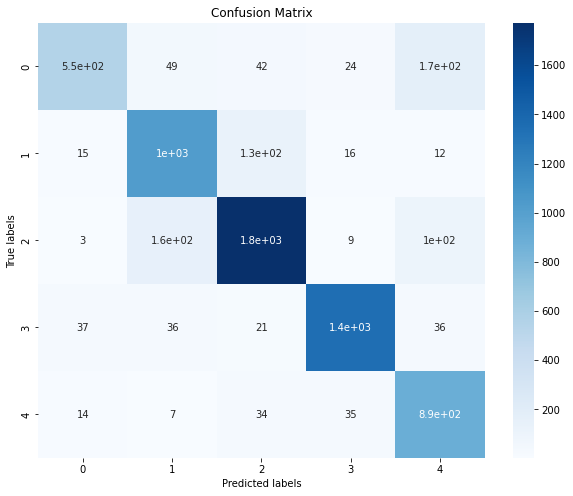

In [7]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_names = [0, 1, 2, 3, 4]
print('accuracy score', accuracy_score(y_true, y_pred))
confusion_mtx = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
cr = classification_report(y_true, y_pred)
print(cr)
sns.heatmap(confusion_mtx, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [8]:
print(confusion_mtx)

[[ 552   49   42   24  171]
 [  15 1029  131   16   12]
 [   3  155 1772    9  100]
 [  37   36   21 1350   36]
 [  14    7   34   35  890]]
